In [1]:
import apache_beam   # Needs to be imported separately to avoid TypingError
import weatherbench2
import xarray as xr

In [2]:
ds = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr')
print(ds)

<xarray.Dataset>
Dimensions:                                           (time: 561264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/48)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (ti

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

learning_rate = 1e-3
training_epochs = 3
batch_size = 2

In [4]:
import gc
gc.collect()

0

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # 훈련 데이터셋과 테스트 데이터셋을 분할할 때 사용한다.
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

key = list(ds.keys())

def normalize_data(data):
    # 최솟값을 0으로 조정
    min_value = data.min()
    
    # 정규화
    normalized_data = (data - min_value) / (data.max() - min_value)
    
    return normalized_data

class CustomDataset(Dataset):
    def __init__(self, data_array, transform=None):
        self.data_array = data_array
        self.transform = transform

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, idx):
        sample = self.data_array[idx].values
        if self.transform:
            sample = self.transform(sample)

        return sample

def load_data(ds, var_name, batch_size=50, year=None):
    if year is not None:
        start_date = pd.to_datetime(f"{year}-01-01")
        end_date = pd.to_datetime(f"{year+1}-01-01")
        ds = ds.sel(time=slice(start_date, end_date))

    print("데이터셋 분리")
    arr = ds[var_name]
    arr = arr.persist()
    print(arr)
    normalize_transform = transforms.Lambda(normalize_data)

    train_dataset, valid_dataset = train_test_split(arr, test_size=0.15, random_state=0)
    print("데이터셋 분리 완료")
    # Use a custom dataset class with proper transformations
    train_data = CustomDataset(train_dataset, transform=transforms.Compose([transforms.ToTensor(), normalize_transform]))
    valid_data = CustomDataset(valid_dataset, transform=transforms.Compose([transforms.ToTensor(), normalize_transform]))
    print("커스텀 데이터셋 완료")
    # Use DataLoader with the custom dataset
    train_data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(dataset=valid_data, batch_size=2, shuffle=True)
    print("데이터 로더")
    return train_data_loader, valid_data_loader

train_data_loader, valid_data_loader = load_data(ds, key[0], batch_size=batch_size, year=2022)
print(len(train_data_loader))

데이터셋 분리


KeyboardInterrupt: 

In [6]:
import torch, gc
%load_ext autoreload
%autoreload 2
from U2Net import U2Net_Light
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

gc.collect()

device = torch.device('mps' if torch.cuda.is_available else 'cpu')

model = U2Net_Light(in_ch=1, out_ch=1).to(device)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
def acc_fn(y_pred, y_true):
    accuracy = torch.eq(y_pred, y_true).sum().item()/len(y_pred)
    return accuracy

def evaluate(model, valid_data_loader, criterion, device):
  val_loss = 0
  val_total = 0
  val_accu = 0
  val_total_pix = 0

  model.eval()

  with torch.no_grad():
    for batch_X in valid_data_loader:
      batch_X = batch_X.to(device)
      output = model(batch_X)[0]
      loss = criterion(output, batch_X)
      _, predicted = torch.max(output, 1)
      val_loss += loss.item()
      val_total += batch_X.size(0)
      val_accu += acc_fn(predicted, batch_X)
      val_total_pix += batch_X.nelement()

  val_loss /= val_total
  val_accu /= val_total_pix

  return val_loss, val_accu

In [8]:
def train(model, train_data_loader, valid_data_loader, criterion, device, max_epoch=3):
    best_val_loss = float('inf')

    for epoch in range(max_epoch):
        train_loss = 0
        train_total = 0
        train_accu = 0
        train_total_pix = 0

        for i, (batch_X) in enumerate(train_data_loader):
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            output = model(batch_X)[0]
            loss = criterion(output, batch_X)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(output, 1)
   
            train_loss += loss.item()
            train_total += batch_X.size(0)
            train_accu += acc_fn(predicted, batch_X)
            train_total_pix += batch_X.nelement()

            writer.add_scalar("Loss/train", loss, i)
            writer.add_scalar("Loss/accuracy", acc_fn(predicted, batch_X) / batch_X.nelement(), i)

        train_loss /= train_total

        val_loss, val_accu = evaluate(model, valid_data_loader, criterion, device)

        print(f'Epoch {epoch+1}/{max_epoch}:')
        print(f'Train Loss: {train_loss: .4f}')
        print(f'Validation Loss: {val_loss: .4f}')
        print(f'Validation Accuracy: {val_accu: .4f}')

        if val_loss < best_val_loss:
            print(f'Validation loss imporved {best_val_loss: .4f} -> {val_loss : .4f}, 체크포인트를 저장합니다.')
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_checkpoint.pth')

        writer.close()
    

In [ ]:
train(model, train_data_loader, valid_data_loader, criterion, device)

/workspace/weather/venv/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor([[[[0.7309, 0.6785, 0.6992,  ..., 0.4978, 0.6093, 0.7196],
          [0.7070, 0.6519, 0.6969,  ..., 0.4929, 0.6061, 0.7033],
          [0.6324, 0.6270, 0.6168,  ..., 0.4373, 0.5426, 0.6965],
          ...,
          [0.5762, 0.5526, 0.5019,  ..., 0.4840, 0.5129, 0.5802],
          [0.5595, 0.5307, 0.4974,  ..., 0.4661, 0.4726, 0.5048],
          [0.5674, 0.5285, 0.5179,  ..., 0.4527, 0.4767, 0.5034]]],


        [[[0.7849, 0.7278, 0.7581,  ..., 0.4471, 0.5641, 0.6939],
          [0.7386, 0.6620, 0.7052,  ..., 0.3887, 0.5136, 0.6201],
          [0.6330, 0.5907, 0.6065,  ..., 0.2790, 0.3774, 0.5265],
          ...,
          [0.5849, 0.5120, 0.4520,  ..., 0.3451, 0.4109, 0.4751],
          [0.4961, 0.4774, 0.4464,  ..., 0.4385, 0.4263, 0.4389],
          [0.4523, 0.4402, 0.4679,  ..., 0.5067, 0.5031, 0.4986]]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6065, 0.5759, 0.5933,  ..., 0.5220, 0.5446, 0.6138],
          [0.5921, 0.5265, 0.5851,  ..., 0.4983, 0.52

KeyboardInterrupt: 

[Test 1]


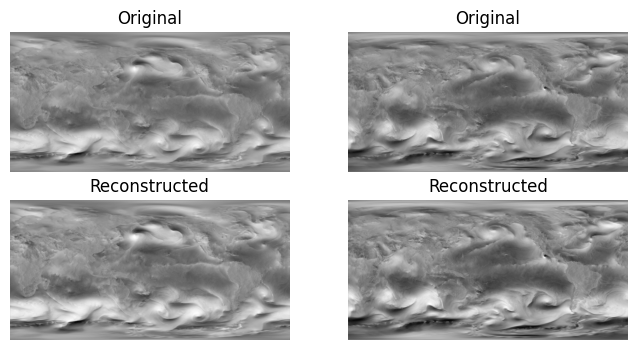

[Test 2]


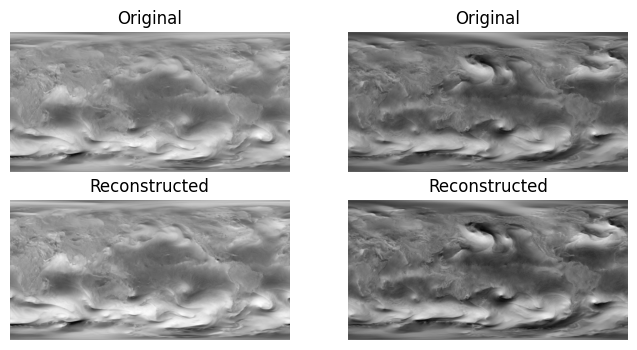

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, data_loader, num_visualize=2):
    model.eval()

    with torch.no_grad():
        for i, (batch_X) in enumerate(data_loader):
            if i >= num_visualize:
                break
            batch_X = batch_X.to(device)
            outputs = model(batch_X)[0]

            # 시각적 비교 코드 (예시)
            plt.figure(figsize=(8, 4))

            print("[Test {}]".format(i+1))

            for j in range(batch_X.size(0)):
                plt.subplot(2, num_visualize, j + 1)
                plt.imshow(batch_X[j].squeeze().cpu().numpy(), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, num_visualize, j + 1 + num_visualize)
                plt.imshow(outputs[j].squeeze().cpu().numpy(), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')

            plt.show()


visualize_reconstructions(model, valid_data_loader)
